In [19]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
import matplotlib.colors as colors

In [23]:
data = xr.open_dataset('./data/SCHISM_SNS_surfTSC_2020.nc')
type(data)
# print(data)


#change the variable name
data = data.rename({"TSC g per l": "SPM"})


data_SPM_nonan=np.where(np.isnan(data.SPM.values), 0., data.SPM.values*1000)
print(f'data.SPM.values before log10, min(data.SPM.values) {np.min(data_SPM_nonan)} and max(data.SPM.values) {np.max(data_SPM_nonan)}' )


print(data)

# #log 10 of 1000*
# data.SPM.values = np.log10(1000*data_SPM_nonan)

data.SPM.values before log10, min(data.SPM.values) 0.0 and max(data.SPM.values) 1799.64697265625
<xarray.Dataset>
Dimensions:    (time: 330, lon: 1151, lat: 601)
Coordinates:
  * time       (time) float64 7.378e+05 7.378e+05 ... 7.381e+05 7.381e+05
Dimensions without coordinates: lon, lat
Data variables:
    longitude  (lon, lat) float64 ...
    latitude   (lon, lat) float64 ...
    SPM        (time, lon, lat) float32 nan nan nan nan nan ... nan nan nan nan
    mask       (lon, lat) float32 ...


(1151, 601)
0.0 1.7960048


/tmp/ipykernel_20384/1384737329.py:3: RuntimeWarning: Mean of empty slice
  mean_tgt = np.nanmean(data.SPM, axis=0)#.sel(time='2017')


Text(0.5, 1.0, 'Mean of physical values')

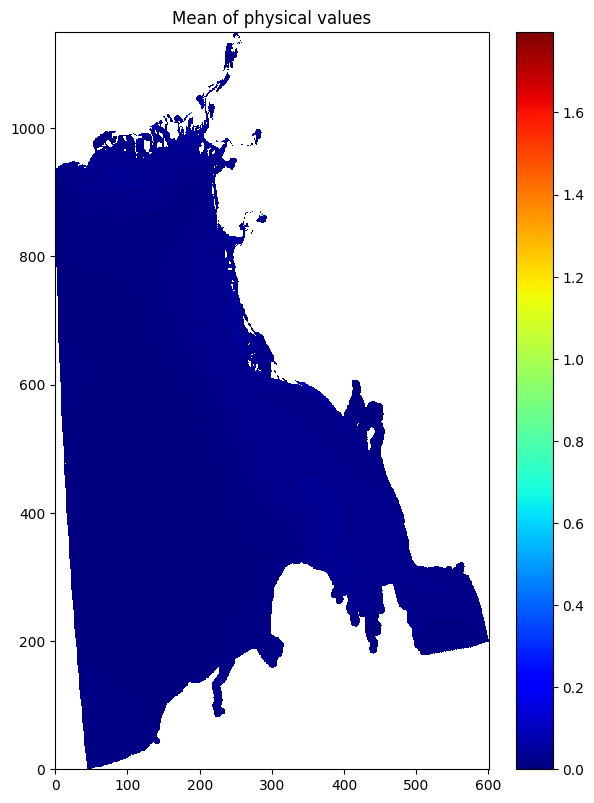

In [24]:
nlat = data.lat.size
nlon = data.lon.size
mean_tgt = np.nanmean(data.SPM, axis=0)#.sel(time='2017')

vmin = np.nanmin(mean_tgt)
vmax = np.nanmax(mean_tgt)

print(mean_tgt.shape)
print(vmin,vmax)
fig=plt.figure(figsize=[5+2, 5*(nlon/nlat)])
plt.pcolormesh( data.lat,data.lon, mean_tgt, cmap='jet',vmin=vmin,vmax=vmax)#to get same size I have to -1 here
plt.colorbar()
plt.title('Mean of physical values')

In [25]:
# Crop the data
data_cropped = data.SPM.isel(lon=slice(600, 840)).isel(lat=slice(100, 400))

print(data_cropped)

# Create and Save a new Dataset
new_data = xr.Dataset({
    'SPM': data_cropped
})

print(new_data)

<xarray.DataArray 'SPM' (time: 330, lon: 240, lat: 300)>
array([[[0.000131, 0.000137, ...,      nan,      nan],
        [0.000132, 0.000137, ...,      nan,      nan],
        ...,
        [0.001814, 0.001824, ...,      nan,      nan],
        [0.001824, 0.001834, ...,      nan,      nan]],

       [[0.000185, 0.000189, ...,      nan,      nan],
        [0.000186, 0.00019 , ...,      nan,      nan],
        ...,
        [0.002406, 0.002446, ...,      nan,      nan],
        [0.002426, 0.002465, ...,      nan,      nan]],

       ...,

       [[0.005785, 0.005786, ...,      nan,      nan],
        [0.005797, 0.0058  , ...,      nan,      nan],
        ...,
        [0.033128, 0.032822, ...,      nan,      nan],
        [0.033262, 0.03296 , ...,      nan,      nan]],

       [[0.004828, 0.004822, ...,      nan,      nan],
        [0.004837, 0.004833, ...,      nan,      nan],
        ...,
        [0.027311, 0.02704 , ...,      nan,      nan],
        [0.027437, 0.027168, ...,      nan,    

(240, 300)
0.00052482483 0.1


/tmp/ipykernel_20384/3499363407.py:1: RuntimeWarning: Mean of empty slice
  mean_tgt = np.nanmean(new_data.SPM, axis=0)#.sel(time='2017')


Text(0.5, 1.0, 'Mean of physical values')

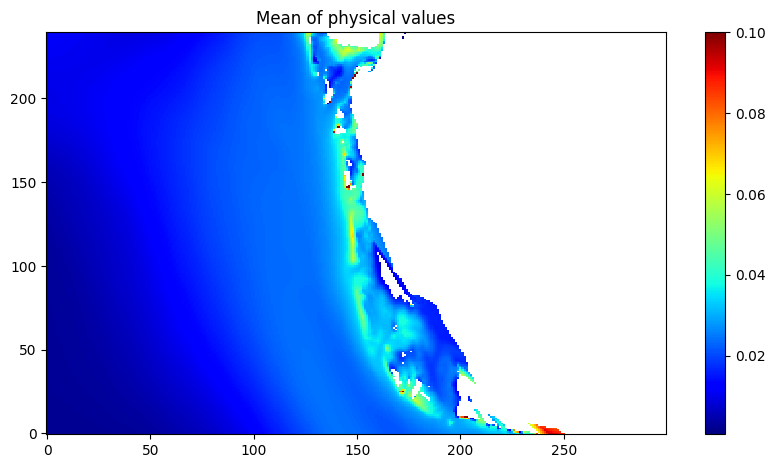

In [26]:
mean_tgt = np.nanmean(new_data.SPM, axis=0)#.sel(time='2017')
print(mean_tgt.shape)

vmin = np.nanmin(mean_tgt)
vmax = 0.1#np.nanmax(mean_tgt)

print(vmin,vmax)
fig=plt.figure(figsize=[10, 10*(nlat/nlon)])
plt.pcolormesh( new_data.lat,new_data.lon, mean_tgt, cmap='jet',vmin=vmin,vmax=vmax)
plt.colorbar()
plt.title('Mean of physical values')



In [27]:
#: Write the modified dataset to a new NetCDF file
new_dataset=new_data
new_dataset.to_netcdf('./data/data_cropped.nc')

In [28]:
#check values min and max of the whole data (and rescale log10 if needed, data SCHISM here doesn't need rescaling)
data_SPM_nonan=np.where(np.isnan(new_dataset.SPM.values), 0., new_dataset.SPM.values)
print(f'data values before log10, min {np.min(data_SPM_nonan)} and max {np.max(data_SPM_nonan)}' )

print('np.unique(data_SPM_nonan) before log 10', np.unique(data_SPM_nonan))


data values before log10, min 0.0 and max 0.9897486567497253
np.unique(data_SPM_nonan) before log 10 [0.0000000e+00 2.6509045e-19 2.6598923e-19 ... 9.6744436e-01 9.7739697e-01
 9.8974866e-01]


In [29]:
########################
##### land mask ########
########################
mask = np.where(np.isnan(new_dataset.SPM.values), 0., 1.)
print('mask.shape',mask.shape)
nt = len(new_dataset.time)
print('nt: ', nt)
#print('mask: ', mask)
land_mask = np.float64(np.sum(mask==0,0)==nt)#axis=0 of the numpy.sum, land_mask shape (78,289) contains 0 and 1, 1 only at the place when all time-series x is NOT nan at that pixel
print('land_mask.shape',land_mask.shape)
land_mask[np.where(land_mask==0)] = np.nan
land_mask = xr.DataArray(land_mask,name="mask",coords=[new_dataset.lon,new_dataset.lat],dims=['lon','lat'])
print('land_mask after format as Xarray: ', land_mask)

#this 2 below is just to save the file containing land_mask
land_mask_file = './data/land_mask.nc'
land_mask.to_netcdf(land_mask_file)

mask.shape (330, 240, 300)
nt:  330
land_mask.shape (240, 300)
land_mask after format as Xarray:  <xarray.DataArray 'mask' (lon: 240, lat: 300)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 232 233 234 235 236 237 238 239
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299


In [30]:
#create obs_patches by removed patches 
##########################
#### Patch (from 0 to 50%) Obs. ####
##########################


# ~ lat_min = 52.5
# land_mask = land_mask.values#note that land_mask contains only 0 and 1

lon = new_dataset.lon
lat = new_dataset.lat

n_land_pix = np.nansum(land_mask)# sum of array elements over a given axis treating Not a Numbers (NaNs) as zero.==> number of 1-pixels
n_sea_pix = land_mask.size-n_land_pix# numbe of 0-pixels

np.random.seed(10)
for t in range(new_dataset.time.size):
    mask_patch = np.where(np.isnan(new_dataset.SPM[t].values),np.nan,1)#mask_patch contains only nan and 1, nan at places that SPM values is nan, and 1 otherwise

    #p_mv is the ratio of nan-pixels to sea-pixels, so if it's bigger than 0.75, then we need to cover more sea-pixels with nan-pixels
    p_mv = 1-np.nansum(mask_patch)/n_sea_pix# "np.nansum(mask_patch)/n_sea_pix" Oh, is it a problem here? n_sea_pix is to count #nan in all series, and np.nansum(mask_patch) is to count #NOT nan in the current x_t
    if p_mv <= .75:#i.e, np.nansum(mask_patch)/n_sea_pix bigger than 0.25!! Otherwise, no need to do anything since it is already too small (smaller than 0.25) !!!
        obj_p_mv = 1-.5*(np.nansum(mask_patch)/n_sea_pix)
        while p_mv <= obj_p_mv:#this one is always true since p_mv is always smaller than obj_p_mv
            half_patch_height = np.random.randint(2,10)
            idx_lat = np.random.randint(0,lat.size)
            idx_lon = np.random.randint(0,lon.size)
            mask_patch[np.max([0,idx_lat-half_patch_height]):np.min([lat.size,idx_lat+half_patch_height+1]),np.max([0,idx_lon-half_patch_height]):np.min([lon.size,idx_lon+half_patch_height+1])] = np.nan
            p_mv = 1-np.nansum(mask_patch)/n_sea_pix
                
    new_var = new_dataset.SPM[t].values
    new_var[np.where(np.isnan(mask_patch))] = np.nan

    new_dataset.SPM[t].values = new_var


new_dataset.to_netcdf('./data/Obs_patch.nc')

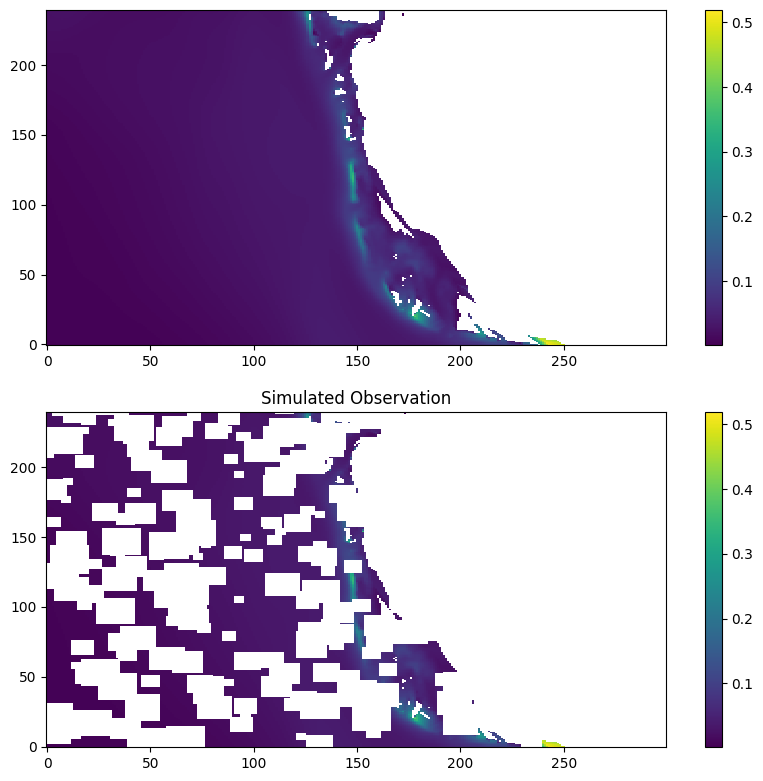

In [33]:
#plot several days only, instead of the animation on whole month

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[2*5, 5*(nlon/nlat)])

t = 29  # Example time index

# Plot for the Ground Truth
mappable0 = ax0.pcolormesh(data_month.lat, data_month.lon, data_month.SPM[t])
ax0.pcolormesh(data_month.lat, data_month.lon, land_mask, cmap='Greys')
# ax0.set_title(data_month.time[t].dt.strftime("%B %d, %Y").values + " Ground Truth")
fig.colorbar(mappable0, ax=ax0)  # Create a colorbar for the first subplot

# Plot for the Simulated Observation
mappable1 = ax1.pcolormesh(data_month.lat, data_month.lon, Obs_month.SPM[t])
ax1.pcolormesh(data_month.lat, data_month.lon, land_mask, cmap='Greys')
ax1.set_title("Simulated Observation")
fig.colorbar(mappable1, ax=ax1)  # Create a colorbar for the second subplot

plt.show()  # Display the plot
